# Fantasy Football LSTM Model (PyTorch)

#### Alvee Hoque

PyTorch implementation of the fantasy football prediction model using LSTM.
Migrated from TensorFlow/Keras for better Windows GPU support.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import timeit

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Sklearn imports
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('white')

In [2]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060


## Load Data

In [3]:
# Reading data
qb = pd.read_csv('fantasy_data/qb_fantasy.csv')
rb = pd.read_csv('fantasy_data/rb_fantasy.csv')
wr = pd.read_csv('fantasy_data/wr_fantasy.csv')
te = pd.read_csv('fantasy_data/te_fantasy.csv')

# Rename the player name column
qb = qb.rename(columns={'Unnamed: 0': 'name'})
rb = rb.rename(columns={'Unnamed: 0': 'name'})
wr = wr.rename(columns={'Unnamed: 0': 'name'})
te = te.rename(columns={'Unnamed: 0': 'name'})

## LSTM Model Definition

In [4]:
class FantasyLSTM(nn.Module):
    """LSTM model for fantasy football predictions."""
    
    def __init__(self, input_size=1, hidden_size=8, output_size=1):
        super(FantasyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden=None):
        # x shape: (batch, seq_len, input_size)
        lstm_out, hidden = self.lstm(x, hidden)
        # Take the last output
        output = self.fc(lstm_out[:, -1, :])
        return output, hidden
    
    def init_hidden(self, batch_size):
        # Initialize hidden state and cell state
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        return (h0, c0)

## Helper Functions

In [5]:
def series_to_supervised(data, lag=1):
    """Convert time series to supervised learning problem."""
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    df.columns = ['X', 'y']
    return df


def ttsplit(dataframe):
    """Train/test split - last 16 games for testing."""
    train, test = dataframe[1:-16].values, dataframe[-16:].values
    return train, test


def scale(train, test):
    """Scale data using MinMaxScaler."""
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled


def invert_scale(scaler, X, value):
    """Invert scaling for a prediction."""
    new_row = [x for x in X] + [value]
    vals = np.array(new_row)
    vals = vals.reshape(1, len(vals))
    inverted = scaler.inverse_transform(vals)
    return inverted[0, -1]

## Training and Prediction Functions

In [6]:
def fit_lstm(train, num_epochs=400, hidden_size=8, learning_rate=0.001):
    """Train LSTM model on the training data."""
    X, y = train[:, 0:-1], train[:, -1]
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X).reshape(-1, 1, 1).to(device)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1).to(device)
    
    # Initialize model
    model = FantasyLSTM(input_size=1, hidden_size=hidden_size, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        # Reset hidden state each epoch (stateful behavior)
        hidden = model.init_hidden(X_tensor.shape[0])
        
        optimizer.zero_grad()
        output, hidden = model(X_tensor, hidden)
        loss = criterion(output, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model


def forecast_lstm(model, X):
    """Make a single prediction."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).reshape(1, 1, -1).to(device)
        output, _ = model(X_tensor)
        return output.cpu().numpy()[0, 0]

## Demo: Test with Single Player

In [7]:
# Select a player to test
player_name = "Tom Brady"
sample_qb = qb[qb.name == player_name]
sample_qb = sample_qb[sample_qb.columns[~sample_qb.isnull().all()]]
print(f"Testing with: {player_name}")
print(f"Data points: {len(sample_qb.values[0][1:])}")

Testing with: Tom Brady
Data points: 335


In [8]:
# Prepare data
X = sample_qb.values[0][1:]
df = series_to_supervised(X)

# Train/test split
train, test = ttsplit(df)

# Scale
scaler, train_scaled, test_scaled = scale(train, test)

print(f"Training samples: {len(train_scaled)}")
print(f"Test samples: {len(test_scaled)}")

Training samples: 318
Test samples: 16


In [9]:
# Train model
start = timeit.default_timer()
model = fit_lstm(train_scaled, num_epochs=400, hidden_size=8)
stop = timeit.default_timer()
print(f"Training time: {stop - start:.2f} seconds")

Training time: 3.16 seconds


In [10]:
# Make predictions
preds = []
for i in range(len(test_scaled)):
    X_test, y_test = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(model, X_test)
    yhat = invert_scale(scaler, X_test, yhat)
    preds.append(yhat)

# Compare predictions vs actual
games = list(range(1, 17))
actual = test[:, 1].tolist()

validation_df = pd.DataFrame({
    'game': games,
    'actual': actual,
    'predicted': preds
})
validation_df

,game,actual,predicted
0,1,9.40,16.655749
1,2,14.74,16.537767
2,3,25.40,17.231535
3,4,17.74,18.946888
4,5,13.72,17.674504
5,6,11.70,17.089444
6,7,17.10,16.821313
7,8,15.20,17.576963
8,9,16.02,17.297056
9,10,18.04,17.416062


<Axes: >

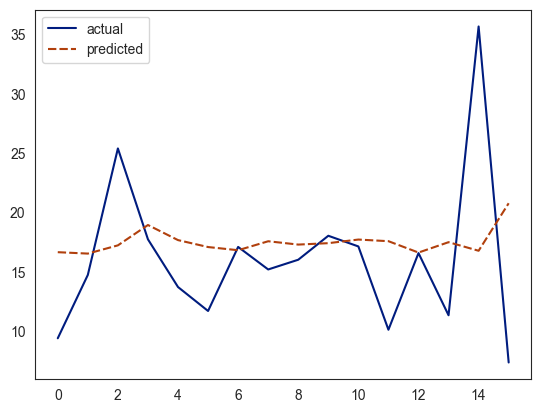

In [11]:
# Visualize results
sns.lineplot(data=validation_df[['actual', 'predicted']], palette='dark')

In [12]:
# Compare totals
print(f"Actual total: {sum(actual):.2f}")
print(f"Predicted total: {sum(preds):.2f}")
print(f"Difference: {abs(sum(actual) - sum(preds)):.2f}")

Actual total: 257.28
Predicted total: 280.23
Difference: 22.95


## Run Model for All Players

In [13]:
def run_model(dataframe, position, min_games=40, num_epochs=400, hidden_size=8):
    """Run LSTM model for all players in a position."""
    
    # Filter players with enough data
    subset = dataframe.count(axis=1) > min_games
    df_subset = dataframe[subset]
    
    print(f"Running {position.upper()} model for {len(df_subset)} players...")
    
    final_actuals = None
    final_preds = None
    
    for row in range(len(df_subset)):
        # Player name
        player_name = df_subset.iloc[row].values[0]
        
        # Player dataframe
        player_df = df_subset[df_subset.name == player_name]
        player_df = player_df[player_df.columns[~player_df.isnull().all()]]
        player_stats = player_df.values[0][1:]
        
        # Supervised learning format
        df_lag = series_to_supervised(player_stats)
        
        # Train/test split
        train, test = ttsplit(df_lag)
        
        # Scale
        scaler, train_scaled, test_scaled = scale(train, test)
        
        # Train model
        model = fit_lstm(train_scaled, num_epochs=num_epochs, hidden_size=hidden_size)
        
        # Predictions
        preds = []
        for i in range(len(test_scaled)):
            X_test, y_test = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(model, X_test)
            yhat = invert_scale(scaler, X_test, yhat)
            preds.append(yhat)
        
        # Store results
        games = list(range(1, 17))
        actual = test[:, 1].tolist()
        
        tmp_name_df = pd.DataFrame(data=[player_name], columns=['name'])
        tmp_actual_df = pd.DataFrame(data=[actual], columns=games)
        tmp_pred_df = pd.DataFrame(data=[preds], columns=games)
        
        if row == 0:
            final_actuals = pd.concat([tmp_name_df, tmp_actual_df], axis=1)
            final_preds = pd.concat([tmp_name_df, tmp_pred_df], axis=1)
        else:
            tmp_final_actual = pd.concat([tmp_name_df, tmp_actual_df], axis=1)
            tmp_final_preds = pd.concat([tmp_name_df, tmp_pred_df], axis=1)
            final_actuals = pd.concat([final_actuals, tmp_final_actual])
            final_preds = pd.concat([final_preds, tmp_final_preds])
        
        # Progress indicator
        if (row + 1) % 10 == 0:
            print(f"  Completed {row + 1}/{len(df_subset)} players")
    
    # Save results
    final_actuals.to_csv(f'actuals/{position}_actual_last16.csv', index=False, header=True)
    final_preds.to_csv(f'predictions/{position}_prediction_last16.csv', index=False, header=True)
    
    print(f"Saved {position.upper()} results to actuals/ and predictions/ folders")
    return final_actuals, final_preds

In [14]:
# Run for QBs
start = timeit.default_timer()
qb_actuals, qb_preds = run_model(qb, 'qb')
stop = timeit.default_timer()
print(f"Total time: {stop - start:.2f} seconds")

Running QB model for 143 players...
  Completed 10/143 players
  Completed 20/143 players
  Completed 30/143 players
  Completed 40/143 players
  Completed 50/143 players
  Completed 60/143 players
  Completed 70/143 players
  Completed 80/143 players
  Completed 90/143 players
  Completed 100/143 players
  Completed 110/143 players
  Completed 120/143 players
  Completed 130/143 players
  Completed 140/143 players
Saved QB results to actuals/ and predictions/ folders
Total time: 127.28 seconds


In [16]:
# Uncomment to run for other positions
run_model(rb, 'rb')
run_model(wr, 'wr')
run_model(te, 'te')

Running RB model for 505 players...
  Completed 10/505 players
  Completed 20/505 players
  Completed 30/505 players
  Completed 40/505 players
  Completed 50/505 players
  Completed 60/505 players
  Completed 70/505 players
  Completed 80/505 players
  Completed 90/505 players
  Completed 100/505 players
  Completed 110/505 players
  Completed 120/505 players
  Completed 130/505 players
  Completed 140/505 players
  Completed 150/505 players
  Completed 160/505 players
  Completed 170/505 players
  Completed 180/505 players
  Completed 190/505 players
  Completed 200/505 players
  Completed 210/505 players
  Completed 220/505 players
  Completed 230/505 players
  Completed 240/505 players
  Completed 250/505 players
  Completed 260/505 players
  Completed 270/505 players
  Completed 280/505 players
  Completed 290/505 players
  Completed 300/505 players
  Completed 310/505 players
  Completed 320/505 players
  Completed 330/505 players
  Completed 340/505 players
  Completed 350/505 p

(               name     1     2     3     4     5     6    7     8     9  \
 0        Aaron Shea   0.0   1.0   1.3   1.5   9.5   3.2  1.4   7.3   0.0   
 0      Aaron Walker   0.0   0.0   0.0   0.0   0.0   1.1  1.4   1.6   3.1   
 0      Adam Shaheen   3.6   2.0   0.8   2.7   0.0   0.0  0.0   2.5   4.3   
 0     Adam Trautman   8.5   0.0   4.2   1.6   0.0   0.0  0.0   3.5   0.7   
 0        Alex Smith   0.0   0.0   0.0   0.0   0.8   6.7  0.0   0.0   0.0   
 ..              ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   
 0         Zach Ertz   1.7  22.2  12.9  10.1  15.4   5.3  3.1   0.0  13.3   
 0       Zach Gentry   0.0   0.0   0.7   6.8   0.9   1.0  0.8   0.0   0.1   
 0       Zach Miller  23.8  10.6  10.8   6.6   5.0  12.3  5.2  13.6   5.9   
 0       Zach Potter   0.0   0.9   0.0   0.0   0.0   0.0  0.0   0.0   0.0   
 0   Zeron Flemister   2.4   0.0   3.7   3.9   0.0   0.0  0.0   0.0   0.0   
 
       10   11   12    13   14    15   16  
 0    0.0  0.0  0.0   1.8  1.9